# Navigation

---

This report evalutes the results of training several agents to solve the Banana environment using the Deep Q-Learning Algorithm. The algorithm is extended by Double DQNs, Dueling DQNs and Prioritized Experience Replay and the results are evaluated and compared. References to the research papers can be found below.


## Starting the Environment



In [1]:
#uncomment if you are running this in the Udacity workspace
!pip -q install ./python

This cell imports the necessary libraries, the agents we want to train, and the training function.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from dqn_agent import Agent, DoubleDQNAgent, PrioritizedExperienceReplayAgent, DuelingDQNAgent, DuelingPERDDQNAgent, DuelingDDQNAgent
from train import train_dqn

Set a random seed to make experiments reproducible.

In [3]:
seed = 0

The following cell loads the environment.

In [4]:
# insert the correct path to the environment below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Some information on the environment:

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


We are going to compare different agents.

In [6]:
agent = Agent(state_size=37, action_size=4, seed=seed)
ddqn_agent = DoubleDQNAgent(state_size=37, action_size=4, seed=seed)
per_agent = PrioritizedExperienceReplayAgent(state_size=37, action_size=4, seed=seed, use_is = True)
dueling_agent = DuelingDQNAgent(state_size=37, action_size=4, seed=seed)
dueling_ddqn_agent = DuelingDDQNAgent(state_size=37, action_size=4, seed=seed)
dueling_ddqn_per_agent = DuelingPERDDQNAgent(state_size=37, action_size=4, seed=seed, use_is = True)

The following function can be used to plot the scores achieved during training.

In [7]:
# function to plot the scores
def plot_scores(scores, plot_title = ""):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.title(plot_title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## Training the agents

### Deep Q-Learning

In Deep Q-Learning, the agent's policy is represented by a neural network. The input is the state `s` of the environment, the output is the expected value of each action `q(s,a)`.
When the agent takes a step in the environment, the state, the action taken, the resulting reward `r` and next state `s'` are saved as an experience in the agent's memory.
Every few steps, the parameters of the agent's Q-Network are updated using a randomly sampled batch of experiences.

To avoid harmful correlations, the agent keeps track of two Q-networks of the same architecture. The local Q-network represents the policy currently used by the agent. The target Q-network is used for determining the estimated action values during learning. The TD error is thus calculated as

\begin{equation} 
r + \gamma \max_{a'} q^{target}(s', a') - q^{local}(s, a)
\end{equation}

The target network evolves more slowly in the direction of the local Q-network and its parameters are updated "softly" according to

\begin{equation}
\theta^{target} = \tau*\theta^{local} + (1 - \tau)*\theta^{target}
\end{equation}

For this whole notebook we choose the following hyperparameter settings:

* the learning rate $ \alpha $: 5e-4
* the soft update rate $ \tau $: 1e-3 
* the exploration probability $ \epsilon$:  starts at a value of $1$ and decays by factor $0.995$ to a final value of $0.01$
* the discount factor $\gamma$: 0.99
* the buffer size of the replay memory: 1e5
* the batch size: 64
* the number of steps after which to update the network: 4


We also fix the architecture of the Q-Network as consisting of three fully connected layers. After each hidden layer we applay a ReLU nonlinearity.

In [9]:
agent.qnetwork_local

QNetwork(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=4, bias=True)
)

We train the agent for 1000 episodes. A checkpoint of the model is saved once the environment is solved. We continue training afterwards in order to see whether we can achieve a higher score. Another checkpoint is saved when all episodes are done.

Episode 100	Average Score: 0.81
Episode 200	Average Score: 3.85
Episode 300	Average Score: 8.03
Episode 400	Average Score: 10.10
Episode 500	Average Score: 12.53
Episode 514	Average Score: 13.02
Environment solved in 414 episodes!	Average Score: 13.02
Episode 600	Average Score: 13.52
Episode 700	Average Score: 14.07
Episode 800	Average Score: 15.15
Episode 900	Average Score: 15.50
Episode 1000	Average Score: 14.96


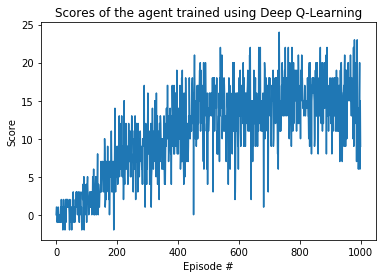

In [14]:
dqn_scores = train_dqn(agent=agent, env=env, n_episodes=1000, 
                       solved_ckpt_path='ckpt_solved.pth', final_ckpt_path='ckpt_final.pth', stop_when_solved=False)
    
plot_scores(dqn_scores, 'Scores of the agent trained using Deep Q-Learning')

Using Deep Q-Learning, we could solve the environment in 414 episodes. After 1000 episodes, the agent reached a score of 14.96. In the following we are going to add improvements to the training algorithm and compare the results

### Double DQN

In order to avoid overestimation of action values, when updating the parameters of the Q-network, we choose the best action using the local network, but estimate its value using the target network. The action $a'$ to be taken in state $s'$ is determined as 

\begin{equation} 
a' = argmax_{a} q^{local}(s,a)
\end{equation}

and the TD error is calculated as
\begin{equation}
r + \gamma q_t^{target}(s', a') - q^{local}(s, a)
\end{equation}

Episode 100	Average Score: 0.33
Episode 200	Average Score: 3.31
Episode 300	Average Score: 7.17
Episode 400	Average Score: 9.09
Episode 500	Average Score: 12.73
Episode 511	Average Score: 13.06
Environment solved in 411 episodes!	Average Score: 13.06
Episode 600	Average Score: 14.37
Episode 700	Average Score: 15.05
Episode 800	Average Score: 15.52
Episode 900	Average Score: 14.97
Episode 1000	Average Score: 16.19


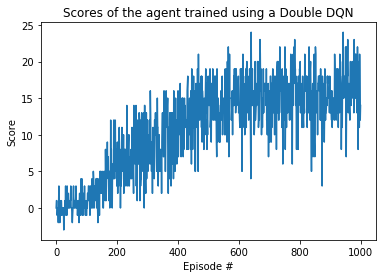

In [8]:
ddqn_scores = train_dqn(agent=ddqn_agent, env=env, n_episodes=1000, 
                        solved_ckpt_path='ckpt_ddqn_solved.pth', final_ckpt_path='ckpt_ddqn_final.pth', stop_when_solved=False)

plot_scores(ddqn_scores, 'Scores of the agent trained using a Double DQN')

Using a double DQN, we could solve the environment in 411 episodes. After 1000 episodes, the agent reached a score of 16.19. 

### Prioritized Experience Replay

Instead of sampling randomly from the experiences, we assign higher probabilities to experiences from which we expect the agent to learn more.
The bigger the difference between the estimated action value and the sum of the actual reward and the estimated value of the next state, the higher the probability that this experience is sampled for training.

We set the following additional hyperparameters:
* the minimum priority of an experience: 1/1e5
* the exponent rescaling the priorities (EXP_A): 0.6
* the exponent rescaling the importance sampling factor (EXP_B): 0.4

Episode 100	Average Score: 0.22
Episode 200	Average Score: 1.79
Episode 300	Average Score: 4.86
Episode 400	Average Score: 7.52
Episode 500	Average Score: 9.16
Episode 600	Average Score: 9.542
Episode 700	Average Score: 10.00
Episode 800	Average Score: 10.75
Episode 900	Average Score: 11.13
Episode 1000	Average Score: 10.82


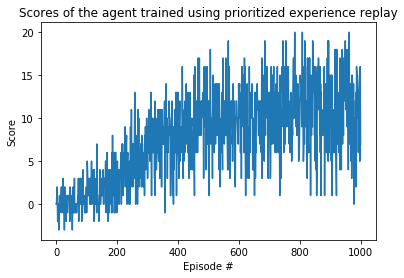

In [8]:
per_scores = train_dqn(agent=per_agent, env=env, n_episodes=1000, 
                        solved_ckpt_path='ckpt_per_solved.pth', final_ckpt_path='ckpt_per_final.pth', stop_when_solved=False)

plot_scores(per_scores, 'Scores of the agent trained using prioritized experience replay')

Using prioritized experience replay, training progressed more slowly. We could not solve the environment within 1000 episodes. There was no significant improvement during the last 300 episodes. The agent seems to have run into a local optimum.

### Dueling DQNs

The DQN estimates the value of each (state, action) pair.
This can be done more efficiently by using the knowledge we already have about the value of a given state $V(s)$.
The value of an action taken in that state is then the sum of the value of the state and the advantage $A(s,a)$ of this action over the greedy action:

\begin{equation}
q(s,a) = V(s) + A(s, a) - max_a A(s,a)
\end{equation}

The dueling DQN architecture "forces" the network to learn the action values according to this formula. The network is split into two branched, one outputting the state values $V(s)$, the other one the action advantages $A(s,a)$. The final output combines the two according to the above formula.


In [9]:
dueling_agent.qnetwork_local

DuelingQNetwork(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (fc2v): Linear(in_features=128, out_features=32, bias=True)
  (fc2a): Linear(in_features=128, out_features=32, bias=True)
  (outputv): Linear(in_features=32, out_features=1, bias=True)
  (outputa): Linear(in_features=32, out_features=4, bias=True)
)

Episode 100	Average Score: 0.50
Episode 200	Average Score: 5.01
Episode 300	Average Score: 8.41
Episode 400	Average Score: 10.82
Episode 486	Average Score: 13.05
Environment solved in 386 episodes!	Average Score: 13.05
Episode 500	Average Score: 13.56
Episode 600	Average Score: 13.92
Episode 700	Average Score: 14.72
Episode 800	Average Score: 14.92
Episode 900	Average Score: 15.39
Episode 1000	Average Score: 15.55


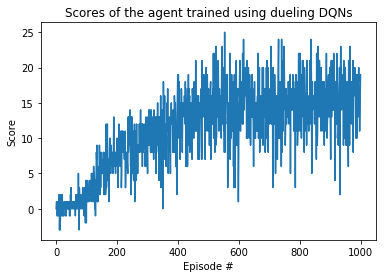

In [8]:
dueling_scores = train_dqn(agent=dueling_agent, env=env, n_episodes=1000, 
                        solved_ckpt_path='ckpt_dueling_solved.pth', final_ckpt_path='ckpt_dueling_final.pth', stop_when_solved=False)

plot_scores(dueling_scores, 'Scores of the agent trained using dueling DQNs')

Using dueling DQNs, we could solve the environment in 386 episodes. After 1000 episodes, the agent reached a score of 15.55.

### Combining Dueling and Double DQNs

Since both double DQNs and dueling DQNs had positive effects, we combine the two and see whether we can further speed up training or achieve better final results.

Episode 100	Average Score: 0.22
Episode 200	Average Score: 3.93
Episode 300	Average Score: 7.26
Episode 400	Average Score: 10.10
Episode 497	Average Score: 13.06
Environment solved in 397 episodes!	Average Score: 13.06
Episode 500	Average Score: 13.23
Episode 600	Average Score: 14.56
Episode 700	Average Score: 15.85
Episode 800	Average Score: 15.66
Episode 900	Average Score: 14.90
Episode 1000	Average Score: 16.24


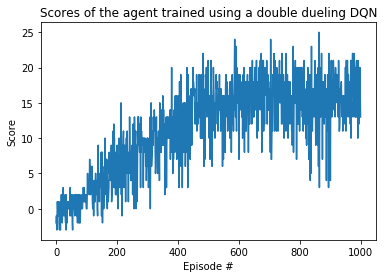

In [9]:
dueling_ddqn_scores = train_dqn(agent=dueling_ddqn_agent, env=env, n_episodes=1000,
                                solved_ckpt_path='ckpt_dueling_ddqn_solved.pth', final_ckpt_path='ckpt_dueling_ddqn_final.pth', stop_when_solved=False)

plot_scores(dueling_ddqn_scores, 'Scores of the agent trained using a double dueling DQN')

Using a double dueling DQN, we could solve the environment in 397 episodes. After 1000 episodes, the agent reached a score of 16.24.

### Combining the Dueling Double DQN and PER

Since PER did not have a positive effect on the training for this environment, we do not expect it to improve the double dueling DQN either, but try it as well for the sake of completeness.

Episode 100	Average Score: 0.99
Episode 200	Average Score: 3.92
Episode 300	Average Score: 8.30
Episode 400	Average Score: 8.28
Episode 500	Average Score: 11.06
Episode 600	Average Score: 11.06
Episode 700	Average Score: 12.73
Episode 800	Average Score: 11.94
Episode 900	Average Score: 10.99
Episode 1000	Average Score: 12.28


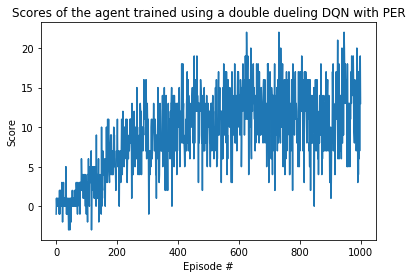

In [10]:
dueling_ddqn_per_scores = train_dqn(agent=dueling_ddqn_per_agent, env=env, n_episodes=1000,
                                solved_ckpt_path='ckpt_dueling_ddqn_per_solved.pth', final_ckpt_path='ckpt_dueling_ddqn_per_final.pth', stop_when_solved=False)

plot_scores(dueling_ddqn_per_scores, 'Scores of the agent trained using a double dueling DQN with PER')

Also here after adding prioritized experience replay the agent was not able to solve the environment within 1000 episodes.

In the end, we close the environment.

In [10]:
env.close()

## Summary and ideas for future work

We trained several agents to solve the banana environment using DQNs to represent the action value function, adding double and dueling DQNs and prioritized experience replay. All agents not using prioritized experience replay were able to solve the environment in less than 420 episodes. 

Ideas for further improvements:
* The experiments in this notebook were done with fixed hyperparameter settings. By carrying out a random hyperparameter search, we could determine better hyperparameter settings, leading to more efficient training.
* Try different network architectures
* In the literature, better results were achieved by combining the improvements to DQNs investigated in this notebook with other improvements: learning from multi-step bootstrap targets, distributional DQN, and noisy DQN. This "rainbow" algorithm might be beneficial also for this environment.


### References

* DQNs: https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
* Double Q-learning: https://arxiv.org/abs/1509.06461
* Prioritized experience replay: https://arxiv.org/abs/1511.05952
* Dueling Network Architecture: https://arxiv.org/abs/1511.06581